<Figure size 5000x3000 with 0 Axes>

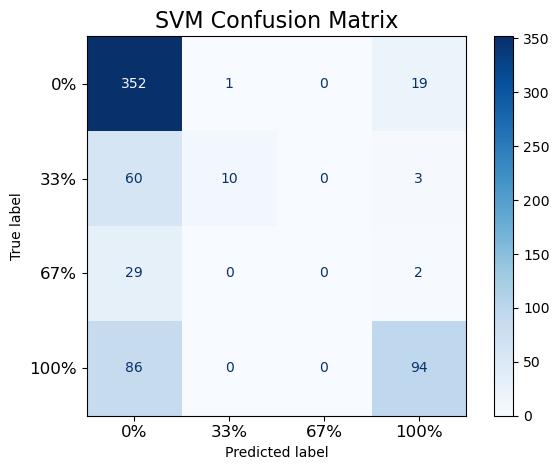

<Figure size 5000x3000 with 0 Axes>

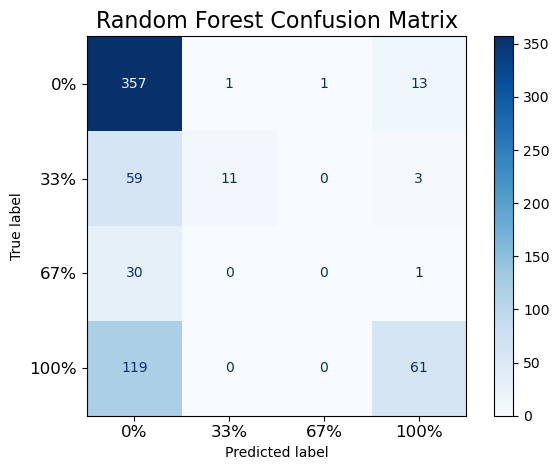

SVM Accuracy: 0.6951
Random Forest Accuracy: 0.6540


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os

# 数据预处理和增强函数
def preprocess_image(image, enhance_contrast=True, equalize_hist=True):
    # 图像去噪
    image = image.filter(ImageFilter.GaussianBlur(radius=1))

    # 直方图均衡化
    if equalize_hist:
        image = ImageOps.equalize(image)

    # 对比度调整
    if enhance_contrast:
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(1.5)  # 对比度增强因子，例如1.5

    return image

# 数据加载函数，不包括数据增强
def load_dataset(fname='labels.csv', new_size=(64, 64)):
    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    dir = os.path.dirname(fname)
    images = []
    for fn in image_fnames:
        with Image.open(os.path.join(dir, fn)) as img:
            # 预处理图像
            processed_img = preprocess_image(img)
            images.append(np.asarray(processed_img.resize(new_size)))

    # 对所有图像进行归一化
    images = np.array(images).astype('float32') / 255.0
    return images, probs, types


# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(50, 30), fontsize=12):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title, fontsize=fontsize+4)
    
    # 增加横纵坐标轴的字体大小
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    
    # 调整边距来确保内容的完整性
    plt.tight_layout()

    plt.show()

# 图像增强函数
def augment_images(images):
    augmented_images = []
    for img_array in images:
        img = Image.fromarray((img_array * 255).astype('uint8'))  # 转换回 PIL 图像
        # 这里可以添加更多的增强操作
        augmented_images.append(np.asarray(img.rotate(90)).astype('float32') / 255.0)  # 旋转并转换回 numpy 数组
    return np.array(augmented_images)

# 标签映射
label_mapping = {
    0.0: '0%',
    0.3333333333333333: '33%',
    0.6666666666666666: '67%',
    1.0: '100%'
}

# 加载数据
images, probabilities, types = load_dataset()

# 将图片数据展平成一维向量
images_flatten = np.array([img.flatten() for img in images])

# 标签编码
le_prob = LabelEncoder()
le_type = LabelEncoder()
labels_prob = le_prob.fit_transform(probabilities)
labels_type = le_type.fit_transform(types)

# 特征拼接，将缺陷概率和电池类型一起作为特征
features = np.column_stack((images_flatten, labels_type))

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(features, labels_prob, test_size=0.25, random_state=42)

# # 仅对训练数据进行数据增强
# augmented_X_train = augment_images(X_train[:, :-1].reshape(-1, 64, 64))
# augmented_X_train_flatten = augmented_X_train.reshape(-1, 64*64)
# X_train_augmented = np.column_stack((augmented_X_train_flatten, X_train[:, -1]))  # 重新加入非图像特征
# X_train_augmented_combined = np.concatenate((X_train, X_train_augmented), axis=0)
# y_train_augmented_combined = np.concatenate((y_train, y_train), axis=0)

# # PCA降维
# pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(X_train_augmented_combined)
# X_test_pca = pca.transform(X_test)


# PCA降维
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# 训练SVM分类器
svm_model = SVC(kernel='rbf', gamma='scale')
svm_model.fit(X_train_pca, y_train)

# 训练随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# 进行预测
svm_predictions = svm_model.predict(X_test_pca)
rf_predictions = rf_model.predict(X_test_pca)

# 计算混淆矩阵
svm_cm = confusion_matrix(y_test, svm_predictions)
rf_cm = confusion_matrix(y_test, rf_predictions)

# 绘制混淆矩阵
plot_confusion_matrix(svm_cm, classes=list(label_mapping.values()), title='SVM Confusion Matrix')
plot_confusion_matrix(rf_cm, classes=list(label_mapping.values()), title='Random Forest Confusion Matrix')

# 打印分类报告
svm_report = classification_report(y_test, svm_predictions, target_names=list(label_mapping.values()), zero_division=0)
rf_report = classification_report(y_test, rf_predictions, target_names=list(label_mapping.values()), zero_division=0)

# 打印精度
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")


<Figure size 5000x3000 with 0 Axes>

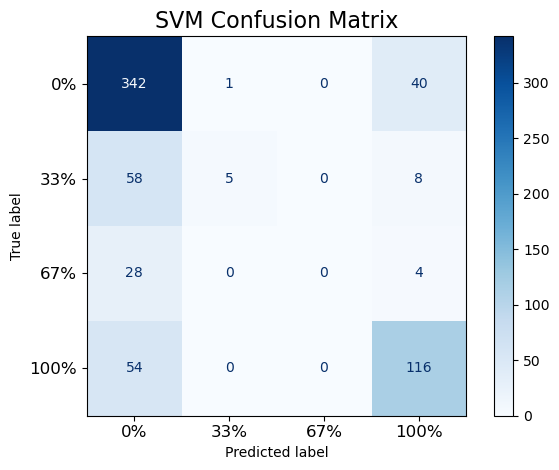

<Figure size 5000x3000 with 0 Axes>

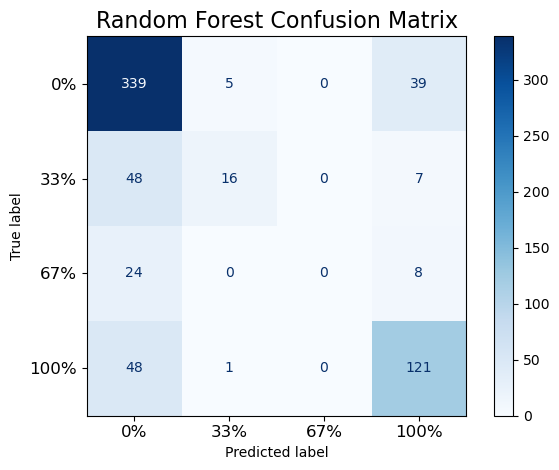

SVM Classification Report:
               precision    recall  f1-score   support

          0%       0.71      0.89      0.79       383
         33%       0.83      0.07      0.13        71
         67%       0.00      0.00      0.00        32
        100%       0.69      0.68      0.69       170

    accuracy                           0.71       656
   macro avg       0.56      0.41      0.40       656
weighted avg       0.68      0.71      0.65       656

Random Forest Classification Report:
               precision    recall  f1-score   support

          0%       0.74      0.89      0.81       383
         33%       0.73      0.23      0.34        71
         67%       0.00      0.00      0.00        32
        100%       0.69      0.71      0.70       170

    accuracy                           0.73       656
   macro avg       0.54      0.46      0.46       656
weighted avg       0.69      0.73      0.69       656

SVM Accuracy: 0.7057926829268293
Random Forest Accuracy: 0.72560

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os
from sklearn.decomposition import IncrementalPCA


# 数据预处理和增强函数
def preprocess_image(image, new_size, enhance_contrast=True, equalize_hist=True):
    # 图像去噪
    image = image.filter(ImageFilter.GaussianBlur(radius=1))

    # 调整图像大小
    image = image.resize(new_size, Image.LANCZOS)

    # # 直方图均衡化
    # if equalize_hist:
    #     image = ImageOps.equalize(image)

    # # 对比度调整
    # if enhance_contrast:
    #     enhancer = ImageEnhance.Contrast(image)
    #     image = enhancer.enhance(1.5)  # 对比度增强因子，例如1.5

    return image


def augment_image(image, new_size):
    # 调整图像大小
    image = image.resize(new_size, Image.LANCZOS)
    # 数据增强：旋转和翻转
    rotations = [0, 90, 180, 270]
    flipped_image = ImageOps.mirror(image)  # 水平翻转
    rotated_images = [image.rotate(angle) for angle in rotations]
    rotated_flipped_images = [flipped_image.rotate(angle) for angle in rotations]
    return rotated_images + rotated_flipped_images


# 修改后的数据加载函数，包括预处理和数据增强
def load_dataset(fname='labels.csv', new_size=(64, 64), augment=False):
    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=['path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    dir = os.path.dirname(fname)
    images = []
    for fn in image_fnames:
        with Image.open(os.path.join(dir, fn)) as img:
            # 预处理图像
            processed_img = preprocess_image(img, new_size)
            images.append(np.asarray(processed_img))
            # 如果启用数据增强
            if augment:
                augmented_imgs = augment_image(processed_img, new_size)
                images.extend(np.asarray(img) for img in augmented_imgs)

    # 对所有图像进行归一化
    images = np.array(images).astype('float32') / 255.0

    # 如果进行了数据增强，则相应地重复概率和类型标签
    if augment:
        probs = np.repeat(probs, 9)  # 1原图 + 4旋转 + 4翻转后旋转
        types = np.repeat(types, 9)

    return images, probs, types


# 转换标签的函数
def map_labels(labels):
    return [label_mapping[label] for label in labels]


# 绘制混淆矩阵的函数
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', figsize=(50, 30), fontsize=12):
    plt.figure(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title, fontsize=fontsize+4)
    
    # 增加横纵坐标轴的字体大小
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    
    # 调整边距来确保内容的完整性
    plt.tight_layout()

    plt.show()



# # 标签映射
# label_mapping = {
#     0.0: 'Fully Functional (0% defect probability)',
#     0.3333333333333333: 'Possibly Defective (33% defect probability)',
#     0.6666666666666666: 'Possibly Defective (67% defect probability)',
#     1.0: 'Definitely Defective (100% defect probability)'
# }

# 标签映射
label_mapping = {
    0.0: '0%',
    0.3333333333333333: '33%',
    0.6666666666666666: '67%',
    1.0: '100%'
}


# 使用自带的加载函数来加载数据
images, probabilities, types = load_dataset(augment=False)

# 将图片数据展平成一维向量
images_flatten = np.array([img.flatten() for img in images])

# 标签编码
le_prob = LabelEncoder()
le_type = LabelEncoder()
labels_prob = le_prob.fit_transform(probabilities)
labels_type = le_type.fit_transform(types)

# 特征拼接，将缺陷概率和电池类型一起作为特征，并转换数据类型
features = np.column_stack((images_flatten, labels_type))
# 标签也转换为 float32 类型
labels_prob = labels_prob

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(features, labels_prob, test_size=0.25, random_state=15)
# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)
# y_train = y_train.astype(np.float32)
# y_test = y_test.astype(np.float32)


# PCA降维
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 训练SVM分类器
svm_model = SVC(kernel='rbf', gamma='scale')
svm_model.fit(X_train_pca, y_train)

# 训练随机森林分类器
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf_model.fit(X_train_pca, y_train)

# 进行预测
svm_predictions = svm_model.predict(X_test_pca)
rf_predictions = rf_model.predict(X_test_pca)

# 计算混淆矩阵
svm_cm = confusion_matrix(y_test, svm_predictions)
rf_cm = confusion_matrix(y_test, rf_predictions)

# 绘制SVM混淆矩阵
plot_confusion_matrix(svm_cm, classes=list(label_mapping.values()), title='SVM Confusion Matrix')

# 绘制随机森林混淆矩阵
plot_confusion_matrix(rf_cm, classes=list(label_mapping.values()), title='Random Forest Confusion Matrix')

# 打印SVM分类报告
svm_report = classification_report(y_test, svm_predictions, target_names=list(label_mapping.values()), zero_division=0)
print("SVM Classification Report:\n", svm_report)

# 打印随机森林分类报告
rf_report = classification_report(y_test, rf_predictions, target_names=list(label_mapping.values()), zero_division=0)
print("Random Forest Classification Report:\n", rf_report)

# 总体精度
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")